# Recurrent Neural Networks (RNNs) for Time Series Forecasting

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

torch.random.manual_seed(17);

Many problems involve sequential data, where the order of the data points (examples) matters. This contrasts with the i.i.d. (independent and identically distributed) assumption we have been working under in all our previous examples. However, many learning tasks involve sequential data, which can be of two main types:

- **Time series sequences:** Time is a dimension of the data in these sequences. Examples include stock prices in a trading app updated every minute, daily temperature readings, or weekly gas prices.
- **Natural language sequences:** These sequences involve characters in words or words in sentences.

Special networks are needed to handle this kind of data. One such network is Recurrent Neural Networks (RNNs).

Recurrent Neural Networks (RNNs) are a class of artificial neural networks designed to handle sequential data. They use recurrent connections, which allow information to persist over time. Unlike the connections of feedforward neural networks, where information flows strictly from input to output in one direction, recurrent connections loop back on themselves, allowing them to maintain an internal state or memory of previous inputs. Here is how a "rolled" (unfolded) recurrent connection looks:

```
                  Input
                    │
                    ▼
             ┌─────────────┐
             │             │──────┐
             │     RNN     │      │ Recurrent Connection
             │             │◄─────┘
             └─────────────┘
                    │
                    ▼
                 Output
```

In this diagram:
- The input is fed into the hidden layer at each time step. This input is combined with the internal state from the previous time step to produce the output and update the internal state for the next time step.
- The output is produced by the hidden layer at each time step.
- The recurrent connection loops back on itself, allowing the RNN hidden layer to maintain an internal state or memory of previous inputs.

However, standard RNNs can suffer from the vanishing gradient problem, making it difficult to learn long-term dependencies. To address this issue, variants of RNNs have been developed, such as Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRUs). 

This notebook focuses on the use of RNNs for time series sequences.

## Forecasting Temperatures

In this example, we'll use the Jena Climate dataset, a popular weather time series dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany. It comprises 14 different features, including air temperature, atmospheric pressure, humidity, and wind direction, recorded every 10 minutes over several years. The dataset covers the period from January 1, 2009, to December 31, 2016.

Let's proceed by downloading and unzipping the data if it hasn't been downloaded yet. Otherwise, we'll read it directly. Pandas' DataFrames work best here.

In [2]:
import requests, zipfile, io, os

data_filename = "./datasets/jena_climate_2009_2016.csv"
if os.path.isfile("./datasets/jena_climate_2009_2016.csv"):
    print("Skipping download...")
    raw_df = pd.read_csv(data_filename)
else:
    url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
    filename = "jena_climate_2009_2016.csv"
    
    zf = zipfile.ZipFile(io.BytesIO(requests.get(url).content)).open(filename)

    raw_df = pd.read_csv(zf)

    raw_df.to_csv(data_filename, index=False)
    
raw_df.head()

Skipping download...


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see, there is a **Date Time** column indicating when the values of the other columns are recorded. This dataset provides one reading every 10 minutes. The date/time values are formatted in the German style (**day.month.year hours24:minutes:seconds**).

Pandas offers a robust set of functions for working with time series data. To convert this DataFrame into a time series, we first need to convert the `Date Time` column from a string to Pandas's "DateTime" type.

In [3]:
raw_df["Date Time"] = pd.to_datetime(raw_df["Date Time"], format="%d.%m.%Y %H:%M:%S")

Let's check the data types of this data frame:

In [4]:
raw_df.dtypes

Date Time          datetime64[ns]
p (mbar)                  float64
T (degC)                  float64
Tpot (K)                  float64
Tdew (degC)               float64
rh (%)                    float64
VPmax (mbar)              float64
VPact (mbar)              float64
VPdef (mbar)              float64
sh (g/kg)                 float64
H2OC (mmol/mol)           float64
rho (g/m**3)              float64
wv (m/s)                  float64
max. wv (m/s)             float64
wd (deg)                  float64
dtype: object

Noticing the data type of the **Date Time** column, we can now proceed to use this date/time column as an index for the entire dataset. Additionally, let's remove any possible duplicates.

In [5]:
df = raw_df.set_index('Date Time').drop_duplicates()
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Having converted the DataFrame into a multivariate time series, let's visualize the behavior of these columns over time by plotting them for the first year.

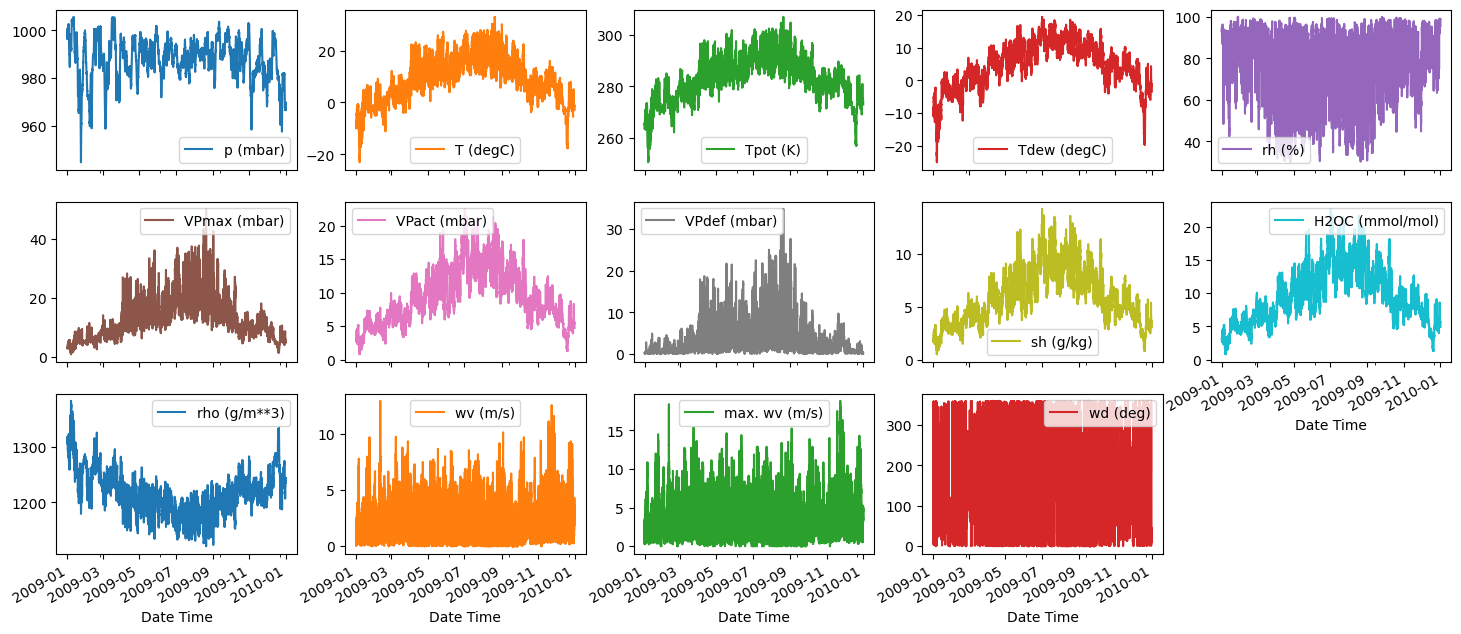

In [6]:
df['2009-01':'2009-12'].plot(subplots=True,layout=(3, 5), figsize=(18, 8))
plt.show()

Having completed the indexing and duplicate removal steps, we are now ready to forecast future temperatures (column `T (degC)`). We can approach this task in two ways:

* **Univariate Time Series Forecasting**: This method utilizes only past temperature values as input for forecasting.
* **Multivariate Time Series Forecasting**: Here, we use multiple columns (or features) as input for forecasting.

## Univariate Time Series Forecasting

In univariate time series forecasting, we predict future values of one column based solely on past values of the same column. For example, we utilize past temperatures to predict future temperatures.

Here is an example of a temperature time series:

In [7]:
ts = df['T (degC)']['2009' : '2016'].to_frame()
ts

,T (degC)
Date Time,
2009-01-01 00:10:00,-8.02
2009-01-01 00:20:00,-8.41
2009-01-01 00:30:00,-8.51
2009-01-01 00:40:00,-8.31
2009-01-01 00:50:00,-8.27
...,...
2016-12-31 23:10:00,-3.93
2016-12-31 23:20:00,-4.05
2016-12-31 23:30:00,-3.35


Let's plot the temperatures of the first five days in 2009.

<Axes: xlabel='Date Time'>

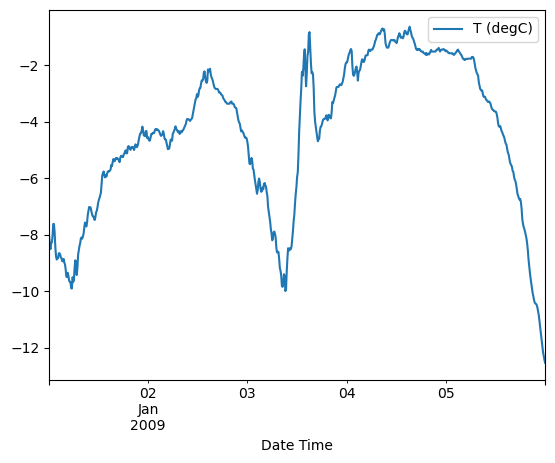

In [8]:
ts['2009-01-01' : '2009-01-05'].plot()

Pandas allows us to resample this time series and change the frequency (resolution) of its time points. Let's plot the temperatures at different frequencies: hourly, daily, monthly, and yearly.

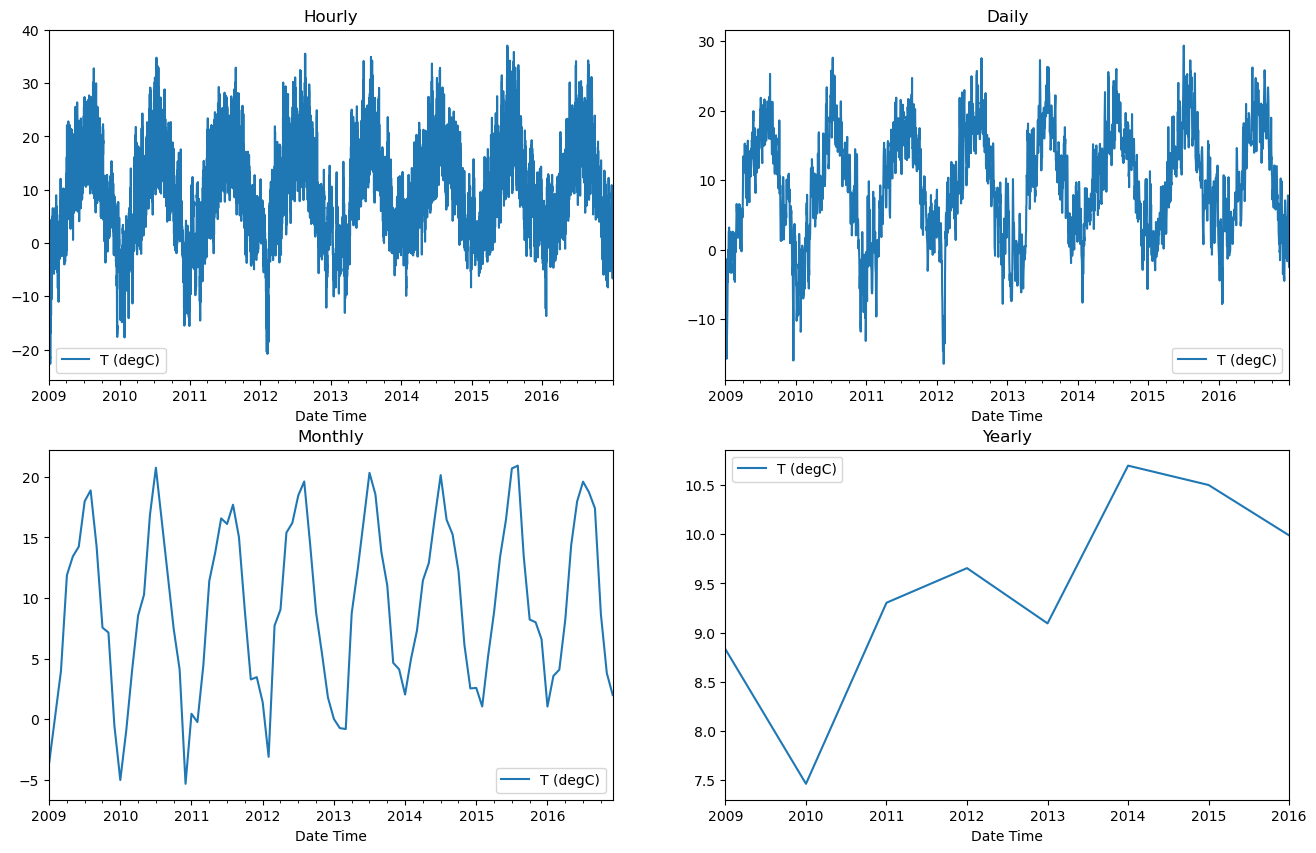

In [9]:
fig, axes = plt.subplots(2,2, figsize=(16, 10))
ts.resample('1h').mean().plot(ax=axes[0, 0], title="Hourly")
ts.resample('1d').mean().plot(ax=axes[0, 1], title="Daily")
ts.resample('1m').mean().plot(ax=axes[1, 0], title="Monthly")
ts.resample('1y').mean().plot(ax=axes[1, 1], title="Yearly")
plt.show()

### Preparing the Data
To prepare this data for training, it's crucial to maintain the order of temperatures by date/time, making sure that they are not shuffled. Therefore, we split the time series into two sets:

* **Training Set**: Data from the period 2009 to 2015.
* **Testing Set**: Data from the year 2016.

Here is the whole time series resampled every six hours. That is the resolution we will be using.

In [10]:
df_hourly = ts.resample('6h').fillna("bfill")
df_hourly

,T (degC)
Date Time,
2009-01-01 00:00:00,-8.02
2009-01-01 06:00:00,-9.67
2009-01-01 12:00:00,-6.87
2009-01-01 18:00:00,-5.25
2009-01-02 00:00:00,-4.54
...,...
2016-12-30 18:00:00,0.51
2016-12-31 00:00:00,-4.09
2016-12-31 06:00:00,-5.27


This dataset is not yet suitable for deep learning. We need to transform it into a format appropriate for forecasting. To illustrate this process, let's consider an example sequence:

```
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
```

We can convert this sequence into a forecasting dataset by taking sequences of a certain length (e.g., 4 elements) as input and using the next fifth element as the output or target. This results in the following dataset:

```
  INPUT                         TARGET
  ====================================
  0, 1, 2, 3                    4
  1, 2, 3, 4                    5
  2, 3, 4, 5                    6
  3, 4, 5, 6                    7
  4, 5, 6, 7                    8
  5, 6, 7, 8                    9
```

In each example, the target or output value represents the future value relative to all values in the input portion of the same example.

Below is a function that converts a given sequence into a dataset in the format described.

In [11]:
def timeseries_dataset_from_array(sequence, targets, sequence_length, start_index=0, end_index=None):
    X, y = [], []
    end_index = (len(sequence) - sequence_length) if end_index is None else end_index
    for i in range(start_index, end_index):
        X.append(sequence[i: i + sequence_length])
        y.append(targets[i])

    return torch.from_numpy(np.array(X)), torch.from_numpy(np.array(y))

We will use the `start_index` and `end_index` parameters to split the data into training and testing sets. Let's apply this function to the example sequence provided above:

In [12]:
sequence = torch.arange(10)
timeseries_dataset_from_array(sequence, sequence[4:], 4)

(tensor([[0, 1, 2, 3],
         [1, 2, 3, 4],
         [2, 3, 4, 5],
         [3, 4, 5, 6],
         [4, 5, 6, 7],
         [5, 6, 7, 8]]),
 tensor([4, 5, 6, 7, 8, 9]))

Using the function provided above, we generate three sets of data: training, validation, and testing, without shuffling. We will use a sequence length of 20, representing one item every six hours for a total of 5 days. The targets correspond to the temperatures after these five days. Below is the code implementing this process:

In [13]:
from torch.utils.data import TensorDataset

inputs = torch.from_numpy(df_hourly.values[:, 0]).float()
targets = inputs[:].float().unsqueeze(dim=1)

num_train_samples = int(0.5 * len(inputs))
num_val_samples = int(0.25 * len(inputs))
num_test_samples = len(inputs) - num_train_samples - num_val_samples

sequence_length = 20
delay = sequence_length

ds_train = TensorDataset(*timeseries_dataset_from_array(
    inputs[:-sequence_length],
    targets[sequence_length:],
    sequence_length,
    start_index=0,
    end_index=num_train_samples))

ds_val = TensorDataset(*timeseries_dataset_from_array(
    inputs[:-sequence_length],
    targets[sequence_length:],
    sequence_length,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples))

ds_test = TensorDataset(*timeseries_dataset_from_array(
    inputs[:-sequence_length],
    targets[sequence_length:],
    sequence_length,
    start_index=num_train_samples + num_val_samples))

len(ds_train), len(ds_val), len(ds_test)

(5844, 2922, 2882)

Let's create the corresponding data loaders:

In [14]:
from torch.utils.data import DataLoader

dl_train = DataLoader(ds_train, batch_size=32, num_workers=4, shuffle=True, 
                      persistent_workers=True, drop_last=True, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size=32, num_workers=4, shuffle=False, 
                    persistent_workers=True, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=32, num_workers=4, shuffle=False, 
                     persistent_workers=True, pin_memory=True)

To ensure everything is correct, let's display the shape of the first batch's input and output:

In [15]:
for samples, targets in dl_train:
    print(" Inputs:", samples.shape)
    print("Targets:", targets.shape)
    break

 Inputs: torch.Size([32, 20])
Targets: torch.Size([32, 1])


### The Base Model

Next, we will create a base Lightning model with all the common methods. It's important to note that we are predicting temperatures, which are real values. Therefore, our loss function should be the mean squared error loss, and our metric should be either the mean squared error or the mean absolute error.

In [16]:
import torch.nn as nn
import lightning as L
from torchmetrics import MeanAbsoluteError

class BaseForecaster(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr
        
        self.train_mae = MeanAbsoluteError()
        self.val_mae = MeanAbsoluteError()
        self.test_mae = MeanAbsoluteError()

    def forward(self, x):
        pass
        
    def _common_step(self, batch, batch_idx, metric, loss_lbl, metric_lbl):
        X, y = batch
        logits = self(X)
        loss = nn.functional.mse_loss(logits, y)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(metric_lbl, metric(logits, y), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_mae, "loss", "mae")

    def on_training_epoch_end(self):
        self.log("mae", self.train_mae.compute())
        self.train_mae.reset()
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_mae, "val_loss", "val_mae")

    def on_validation_epoch_end(self):
        self.log("val_mae", self.val_mae.compute())
        self.val_mae.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.test_mae, "test_loss", "test_mae")

    def on_test_epoch_end(self):
        self.log("test_mae", self.test_mae.compute())
        self.test_mae.reset()
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

We are now prepared to build and train our forecasting models. We will develop three types of models:

* A fully connected network.
* A 1D convolutional network.
* A simple recurrent neural network.

### Using Fully-Connected Network (FCN)
This is a simple multilayer perceptron model with one hidden layer. Here's an outline of its structure:

In [17]:
from torchinfo import summary

class TempFCNForecaster(BaseForecaster):
    def __init__(self, lr=0.001):
        super().__init__(lr)

        self.net = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)
         
fcn_model = TempFCNForecaster()
summary(fcn_model)

Layer (type:depth-idx)                   Param #
TempFCNForecaster                        --
├─MeanAbsoluteError: 1-1                 --
├─MeanAbsoluteError: 1-2                 --
├─MeanAbsoluteError: 1-3                 --
├─Sequential: 1-4                        --
│    └─Linear: 2-1                       1,344
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       65
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0

Let's train this model.

In [18]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="uv_ts_fcn")

trainer = L.Trainer(max_epochs=20, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1, 
        dirpath='checkpoints/', filename='uv_ts_fcn-{epoch:02d}-{val_loss:.2f}', 
    ),
    EarlyStopping(monitor='val_loss', patience=3, mode='min')
], logger=logger)
trainer.fit(fcn_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory checkpoints/ exists and is not empty.

  | Name      | Type              | Params
------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0     
1 | val_mae   | MeanAbsoluteError | 0     
2 | test_mae  | MeanAbsoluteError | 0     
3 | net       | Sequential        | 1.4 K 
------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |                                          | 0/? [00:00<?, ?it/s]

Training: |                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Here are the training and validation learning curves.

array([[<Axes: >, <Axes: >]], dtype=object)

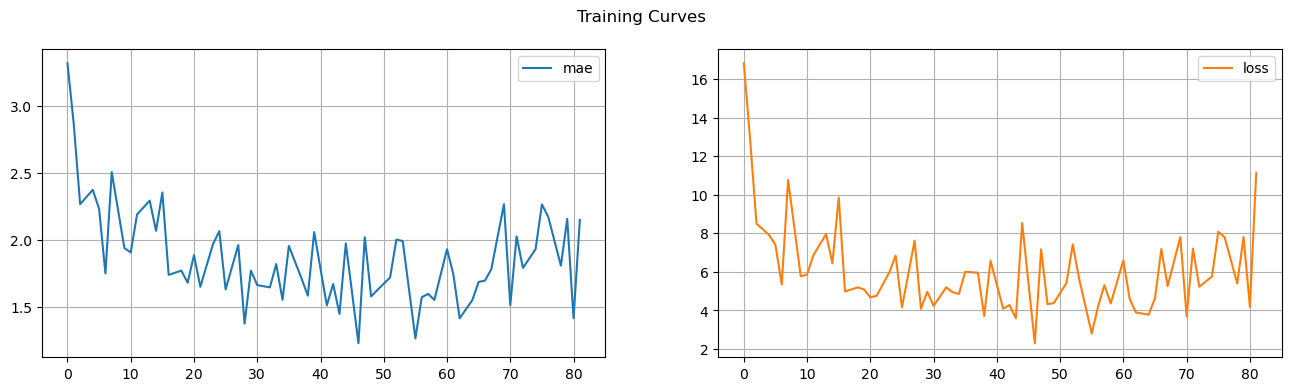

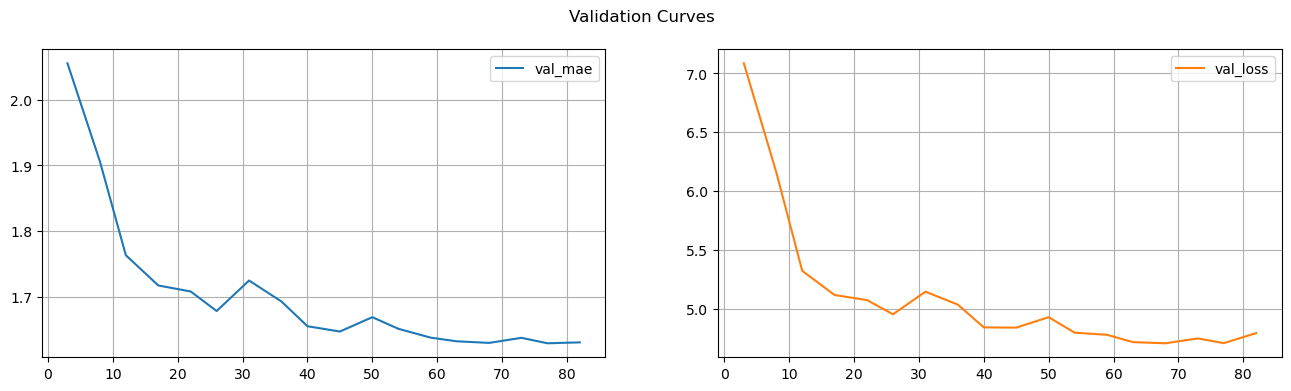

In [19]:
hist = pd.read_csv(f"./logs/uv_ts_fcn/version_{len(os.listdir('./logs/uv_ts_fcn/')) - 1}/metrics.csv")
hist[['mae', 'loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4), 
                                         grid=True, title="Training Curves")
hist[['val_mae', 'val_loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4), 
                                         grid=True, title="Validation Curves")

Let's evaluate this model on the testing dataset.

In [20]:
trainer.test(ckpt_path='best', dataloaders=dl_test)

Restoring states from the checkpoint path at checkpoints/uv_ts_fcn-epoch=14-val_loss=4.71-v1.ckpt
Loaded model weights from the checkpoint at checkpoints/uv_ts_fcn-epoch=14-val_loss=4.71-v1.ckpt


Testing: |                                                  | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5.220202445983887     │
│         test_mae          │    1.7275896072387695     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.220202445983887, 'test_mae': 1.7275896072387695}]

Let's visualize how this model performed by plotting the predicted testing temperatures alongside the actual ones. Additionally, we'll create a scatter plot of actual temperatures against predicted ones. The closer the points on this second plot are to the diagonal line with a slope of 1 and zero intercept, the better the predictions. Since we need these plots for the next models as well, let's create a function for it.

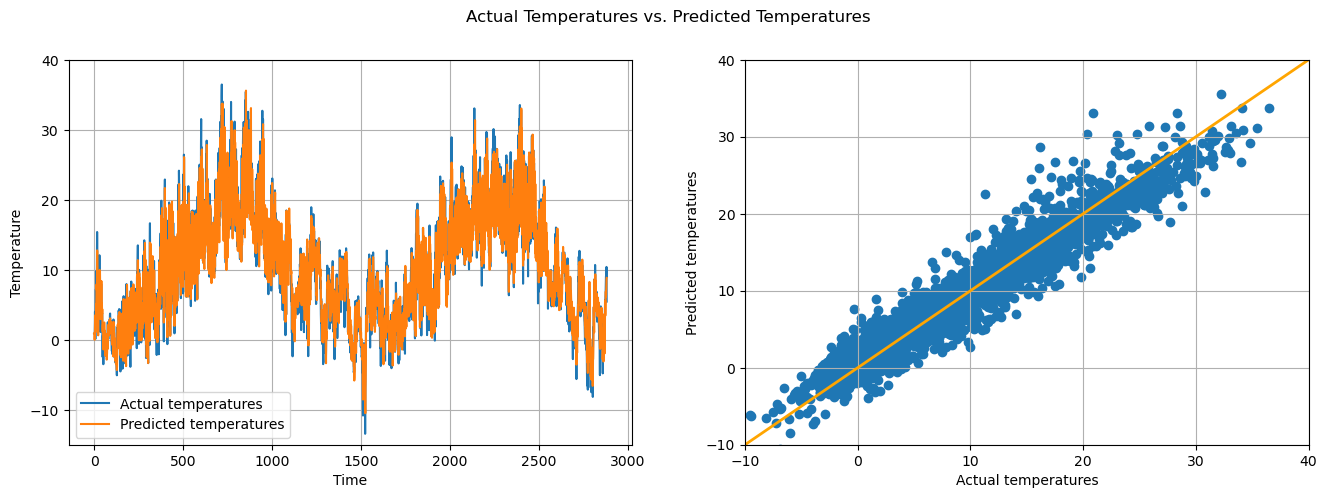

In [21]:
def plot_actual_vs_predicted(model, ds):
    y_hat = model(ds.tensors[0]).detach()
    y = ds.tensors[1]

    fig = plt.figure(figsize=(18,5))
    
    pd.DataFrame(torch.concat((y, y_hat), axis=1), 
        columns=["Actual temperatures", "Predicted temperatures"]).plot(
        layout=[1, 2], grid=True, figsize=(16, 5), ylim=(-15, 40), 
        xlabel="Time", ylabel="Temperature", ax=plt.subplot(1, 2, 1))

    plt.subplot(1, 2, 2)
    plt.scatter(y, y_hat, marker='o')
    plt.axline((0, 0), (1, 1), c='orange', lw=2)
    plt.xlabel("Actual temperatures")
    plt.ylabel("Predicted temperatures")
    plt.axis([-10, 40, -10, 40])
    plt.grid()

    plt.suptitle("Actual Temperatures vs. Predicted Temperatures")

plot_actual_vs_predicted(fcn_model, ds_test)

### Using 1D Convolutional Network (1dCNN)

A 1D convolutional neural network (1D ConvNet) utilizes 1D convolutional and pooling layers to process sequence data. These networks are highly effective for tasks like time series forecasting and have found extensive use in applications such as speech recognition and natural language processing.

Here, we construct a simple 1D ConvNet with two convolutional layers. Notice the use of ``, which reshapes the data to layout expected by the convolutional layer.

In [22]:
class Temp1dCNNForecaster(BaseForecaster):
    def __init__(self, lr=0.001):
        super().__init__(lr)
        
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 8, kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(56, 1)
        )
        
    def forward(self, x):
        x = x.view(-1, 1, 20)
        return self.net(x)
        
cnn_model = Temp1dCNNForecaster()
summary(cnn_model)

Layer (type:depth-idx)                   Param #
Temp1dCNNForecaster                      --
├─MeanAbsoluteError: 1-1                 --
├─MeanAbsoluteError: 1-2                 --
├─MeanAbsoluteError: 1-3                 --
├─Sequential: 1-4                        --
│    └─Conv1d: 2-1                       64
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
│    └─Conv1d: 2-4                       392
│    └─ReLU: 2-5                         --
│    └─Flatten: 2-6                      --
│    └─Linear: 2-7                       57
Total params: 513
Trainable params: 513
Non-trainable params: 0

Let's train this model.

In [23]:
logger = CSVLogger("logs", name="uv_ts_cnn")

trainer = L.Trainer(max_epochs=20, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1, 
        dirpath='checkpoints/', filename='uv_ts_cnn-{epoch:02d}-{val_loss:.2f}', 
    ),
    EarlyStopping(monitor='val_loss', patience=3, mode='min')
], logger=logger)
trainer.fit(cnn_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory checkpoints/ exists and is not empty.

  | Name      | Type              | Params
------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0     
1 | val_mae   | MeanAbsoluteError | 0     
2 | test_mae  | MeanAbsoluteError | 0     
3 | net       | Sequential        | 513   
------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: |                                          | 0/? [00:00<?, ?it/s]

Training: |                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Here are the training and validation learning curves.

array([[<Axes: >, <Axes: >]], dtype=object)

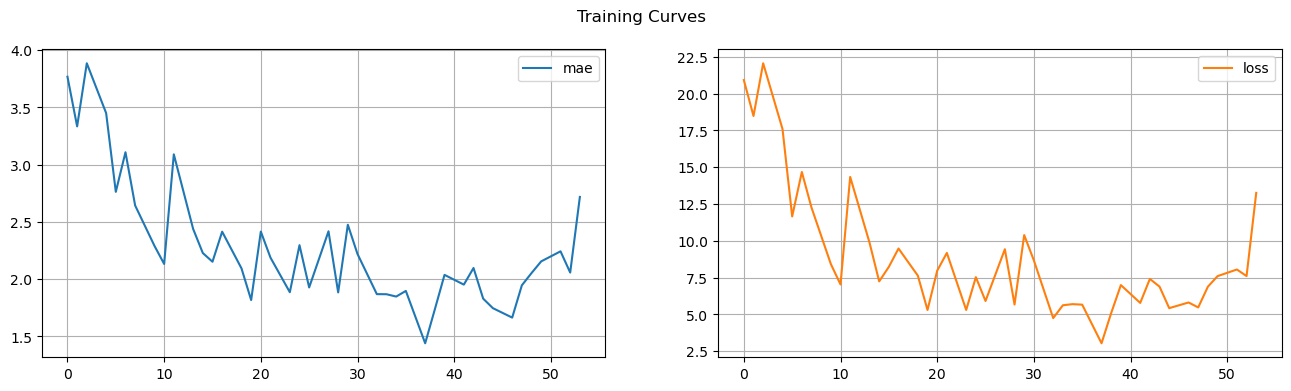

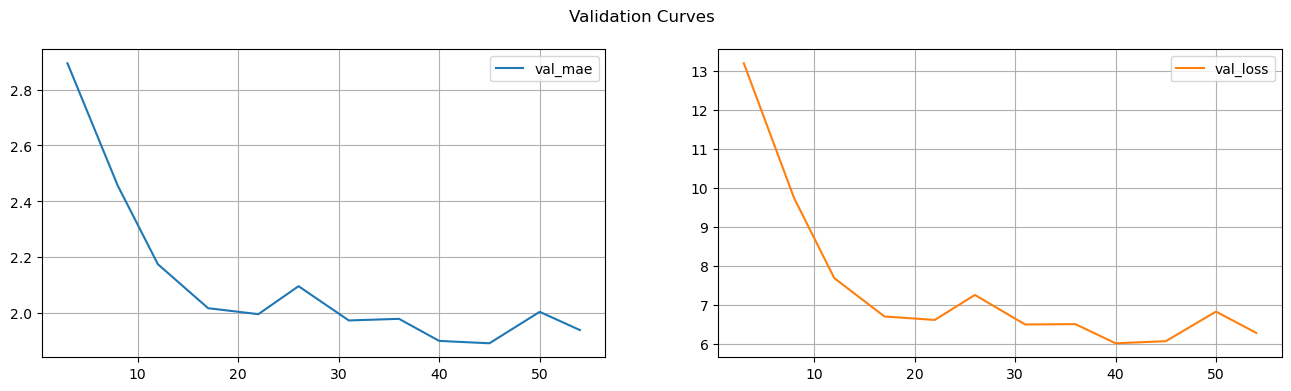

In [24]:
hist = pd.read_csv(f"./logs/uv_ts_cnn/version_{len(os.listdir('./logs/uv_ts_cnn/')) - 1}/metrics.csv")
hist[['mae', 'loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4), 
                                         grid=True, title="Training Curves")
hist[['val_mae', 'val_loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4), 
                                         grid=True, title="Validation Curves")

Let's evaluate this model on the testing dataset.

In [25]:
trainer.test(ckpt_path='best', dataloaders=dl_test)

Restoring states from the checkpoint path at checkpoints/uv_ts_cnn-epoch=08-val_loss=6.03-v1.ckpt
Loaded model weights from the checkpoint at checkpoints/uv_ts_cnn-epoch=08-val_loss=6.03-v1.ckpt


Testing: |                                                  | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     6.775963306427002     │
│         test_mae          │     2.020237684249878     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 6.775963306427002, 'test_mae': 2.020237684249878}]

Let's plot the predicted temperatures alongside the actual ones.

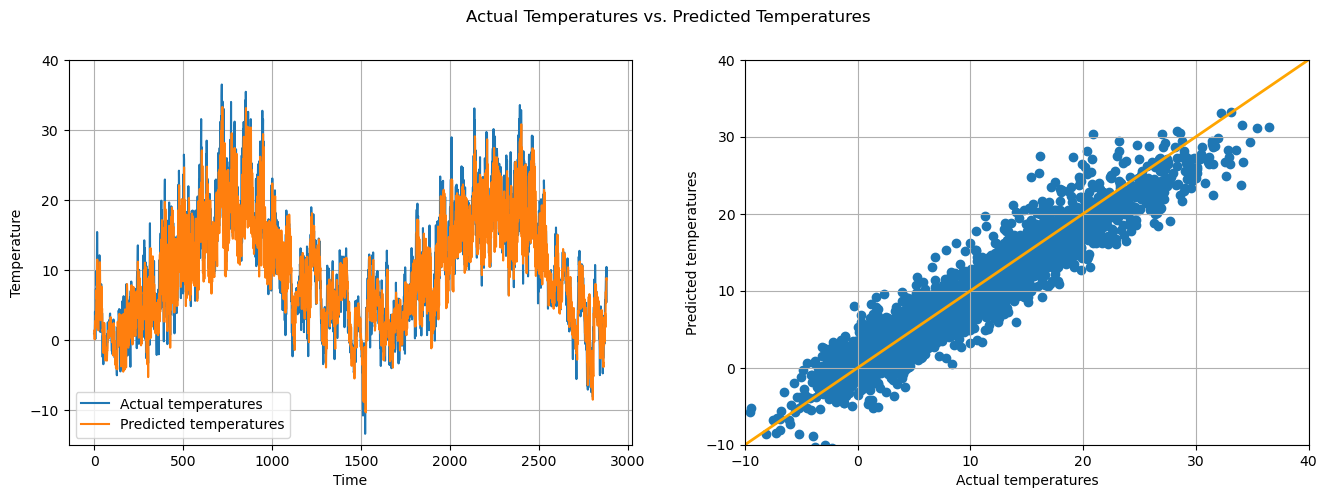

In [26]:
plot_actual_vs_predicted(cnn_model, ds_test)

### Using a Simple Recurrent Neural Network

Here, we model a model consisting of a single `nn.RNN` layer with 16 hidden units, followed by a linear output layer. Since the RNN layer returns both the output and the state, we need to call it manually inside the `forward` method and then pass only the output to the final linear layer.

In [27]:
class TempRNNForecaster(BaseForecaster):
    def __init__(self, lr=0.001, sequence_length=10):
        super().__init__(lr)
        self.sequence_length = sequence_length

        self.rnn = nn.RNN(input_size=1, hidden_size=16, batch_first=True)
        self.out = nn.Linear(320, 1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = x.view(-1, self.sequence_length, 1)
        o, _ = self.rnn(x)
        x = self.flatten(o)
        
        return self.out(x)

rnn_model = TempRNNForecaster(sequence_length=20)
summary(rnn_model)

Layer (type:depth-idx)                   Param #
TempRNNForecaster                        --
├─MeanAbsoluteError: 1-1                 --
├─MeanAbsoluteError: 1-2                 --
├─MeanAbsoluteError: 1-3                 --
├─RNN: 1-4                               304
├─Linear: 1-5                            321
├─Flatten: 1-6                           --
Total params: 625
Trainable params: 625
Non-trainable params: 0

Let's train this model.

In [28]:
logger = CSVLogger("logs", name="uv_ts_rnn")

trainer = L.Trainer(max_epochs=20, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1, 
        dirpath='checkpoints/', filename='uv_ts_rnn-{epoch:02d}-{val_loss:.2f}', 
    ),
    EarlyStopping(monitor='val_loss', patience=3, mode='min')
], logger=logger)
trainer.fit(rnn_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory checkpoints/ exists and is not empty.

  | Name      | Type              | Params
------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0     
1 | val_mae   | MeanAbsoluteError | 0     
2 | test_mae  | MeanAbsoluteError | 0     
3 | rnn       | RNN               | 304   
4 | out       | Linear            | 321   
5 | flatten   | Flatten           | 0     
------------------------------------------------
625       Trainable params
0         Non-trainable params
625       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: |                                          | 0/? [00:00<?, ?it/s]

Training: |                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Here are the training and validation learning curves.

array([[<Axes: >, <Axes: >]], dtype=object)

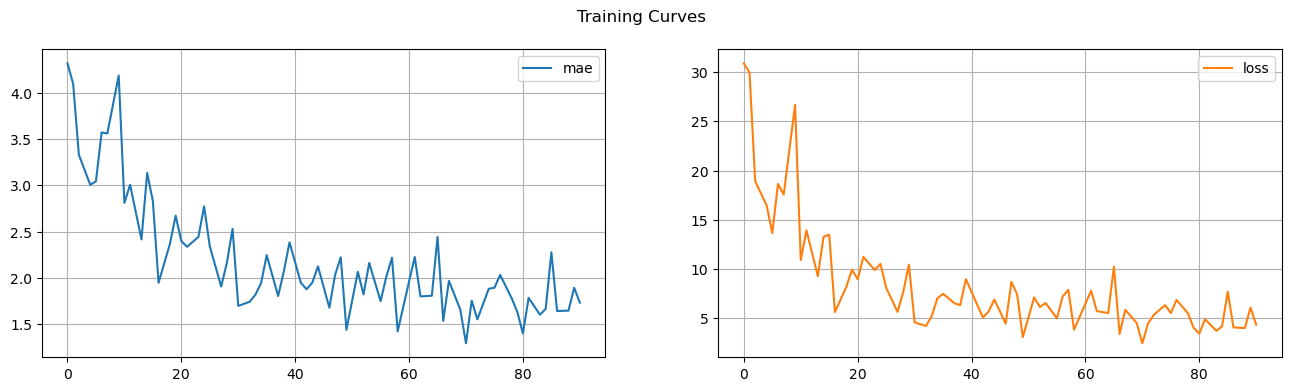

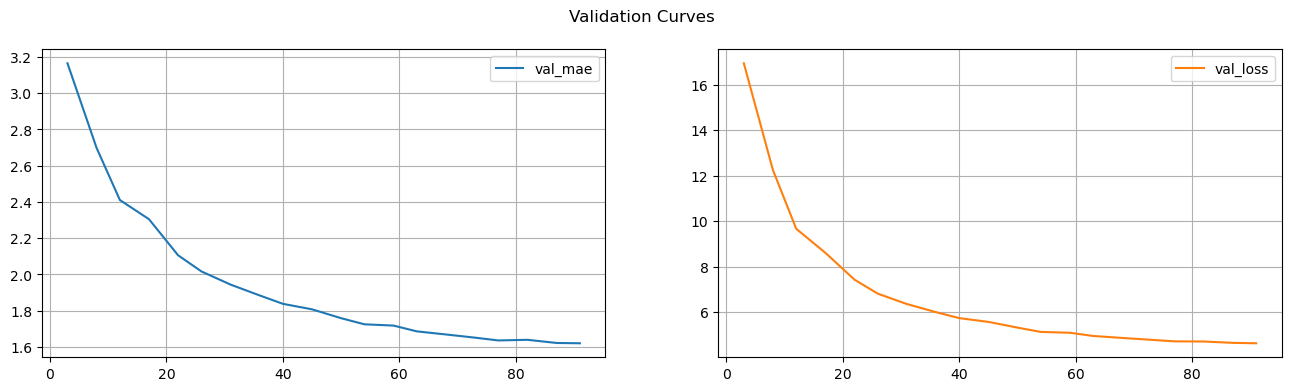

In [29]:
hist = pd.read_csv(f"./logs/uv_ts_rnn/version_{len(os.listdir('./logs/uv_ts_rnn/')) - 1}/metrics.csv")
hist[['mae', 'loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4), 
                                         grid=True, title="Training Curves")
hist[['val_mae', 'val_loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4), 
                                         grid=True, title="Validation Curves")

Let's evaluate this model on the testing dataset.

In [30]:
trainer.test(ckpt_path='best', dataloaders=dl_test)

Restoring states from the checkpoint path at checkpoints/uv_ts_rnn-epoch=19-val_loss=4.63-v1.ckpt
Loaded model weights from the checkpoint at checkpoints/uv_ts_rnn-epoch=19-val_loss=4.63-v1.ckpt


Testing: |                                                  | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5.327709674835205     │
│         test_mae          │    1.7599639892578125     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.327709674835205, 'test_mae': 1.7599639892578125}]

Let's plot the predicted temperatures alongside the actual ones.

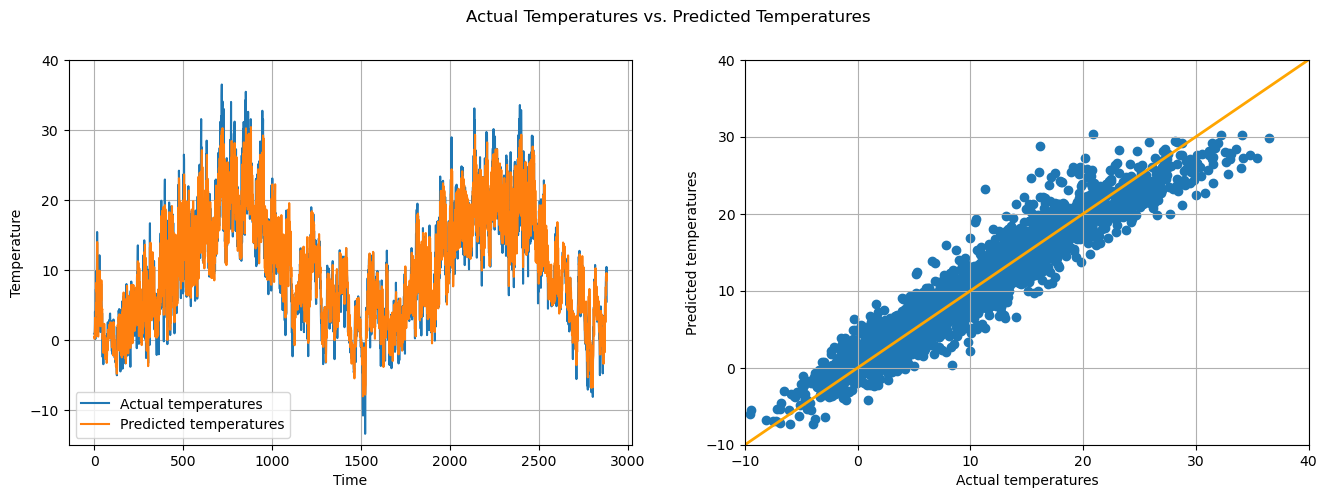

In [31]:
plot_actual_vs_predicted(rnn_model, ds_test)

### Using a GRU (Gated Recurrent Unit) Network

Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) architecture designed to address the vanishing gradient problem and improve learning of long-term dependencies in sequential data. It is similar to Long Short-Term Memory (LSTM) networks but has a simpler architecture with fewer parameters. Here is a simple GRU network.

In [32]:
class TempGRUForecaster(BaseForecaster):
    def __init__(self, lr=0.001, sequence_length=10):
        super().__init__(lr)
        self.sequence_length = sequence_length

        self.gru = nn.GRU(input_size=1, hidden_size=16, batch_first=True)
        self.out = nn.Linear(320, 1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = x.view(-1, self.sequence_length, 1)
        o, _ = self.gru(x)
        x = self.flatten(o)
        return self.out(x)

gru_model = TempGRUForecaster(sequence_length=20)
summary(gru_model)

Layer (type:depth-idx)                   Param #
TempGRUForecaster                        --
├─MeanAbsoluteError: 1-1                 --
├─MeanAbsoluteError: 1-2                 --
├─MeanAbsoluteError: 1-3                 --
├─GRU: 1-4                               912
├─Linear: 1-5                            321
├─Flatten: 1-6                           --
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0

Let's train this model.

In [33]:
logger = CSVLogger("logs", name="uv_ts_gru")

trainer = L.Trainer(max_epochs=20, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1, 
        dirpath='checkpoints/', filename='uv_ts_gru-{epoch:02d}-{val_loss:.2f}', 
    ),
    EarlyStopping(monitor='val_loss', patience=3, mode='min')
], logger=logger)
trainer.fit(gru_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory checkpoints/ exists and is not empty.

  | Name      | Type              | Params
------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0     
1 | val_mae   | MeanAbsoluteError | 0     
2 | test_mae  | MeanAbsoluteError | 0     
3 | gru       | GRU               | 912   
4 | out       | Linear            | 321   
5 | flatten   | Flatten           | 0     
------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: |                                          | 0/? [00:00<?, ?it/s]

Training: |                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Here are the training and validation learning curves.

array([[<Axes: >, <Axes: >]], dtype=object)

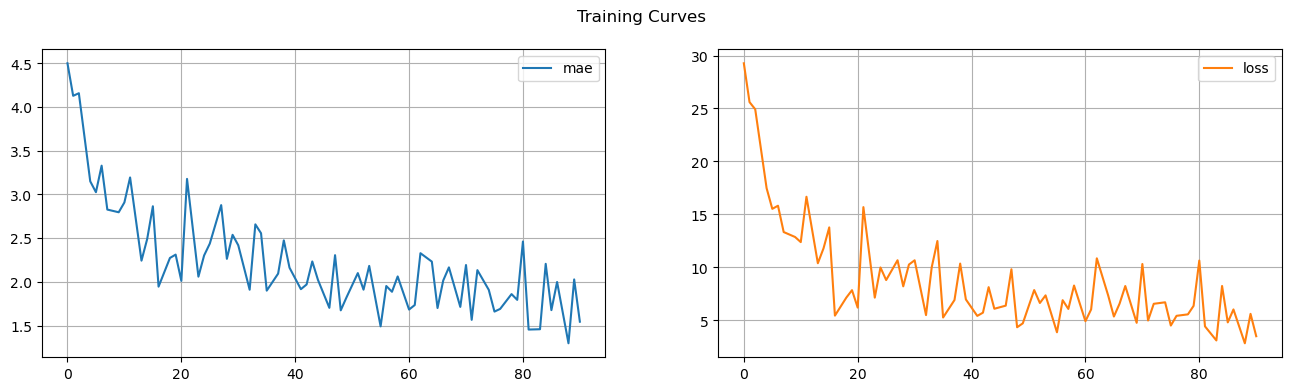

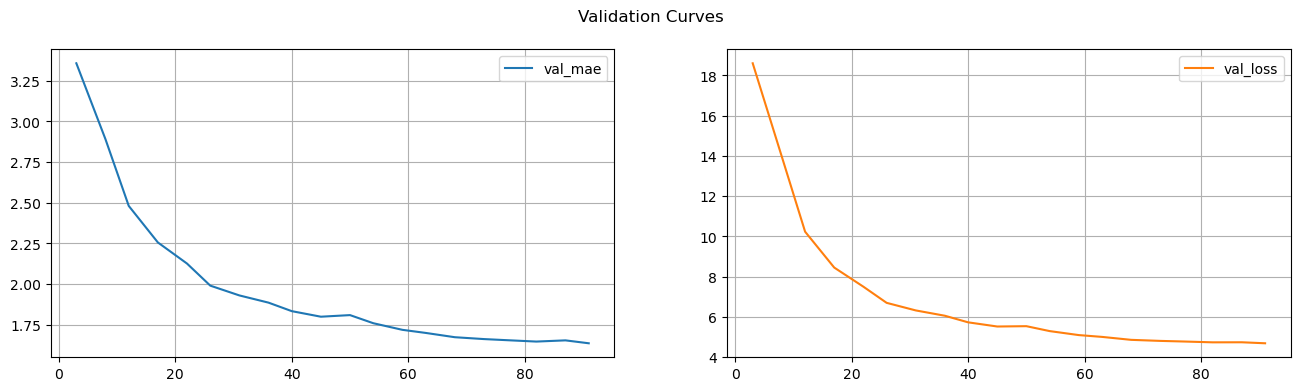

In [34]:
hist = pd.read_csv(f"./logs/uv_ts_gru/version_{len(os.listdir('./logs/uv_ts_gru/')) - 1}/metrics.csv")
hist[['mae', 'loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4), 
                                         grid=True, title="Training Curves")
hist[['val_mae', 'val_loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4), 
                                         grid=True, title="Validation Curves")

Let's evaluate this model on the testing dataset.

In [35]:
trainer.test(ckpt_path='best', dataloaders=dl_test)

Restoring states from the checkpoint path at checkpoints/uv_ts_gru-epoch=19-val_loss=4.69-v1.ckpt
Loaded model weights from the checkpoint at checkpoints/uv_ts_gru-epoch=19-val_loss=4.69-v1.ckpt


Testing: |                                                  | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5.401564598083496     │
│         test_mae          │    1.7771047353744507     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.401564598083496, 'test_mae': 1.7771047353744507}]

Let's plot the predicted temperatures alongside the actual ones.

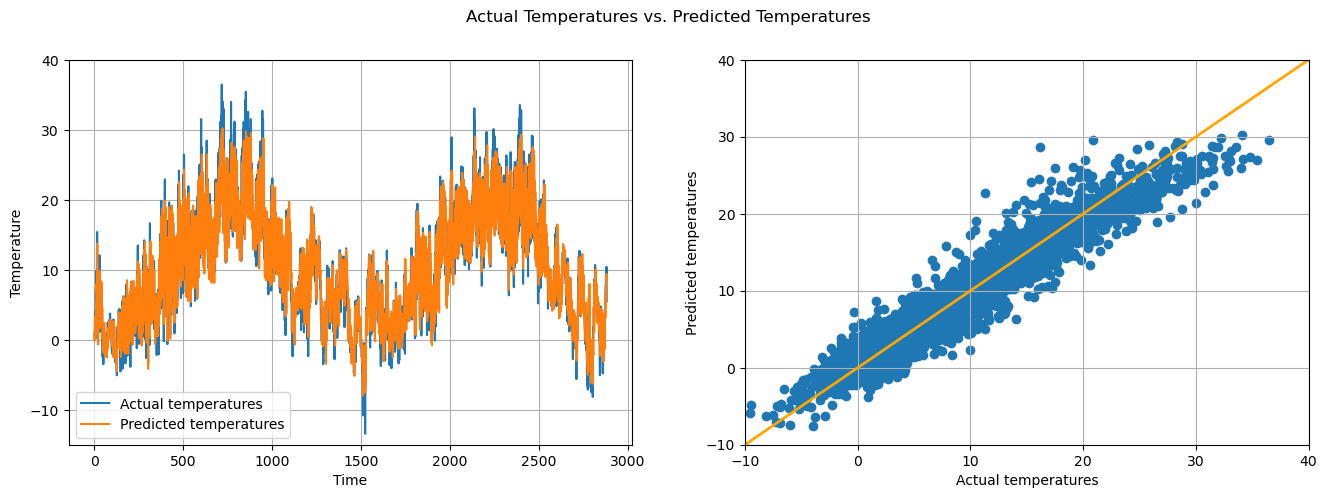

In [36]:
plot_actual_vs_predicted(gru_model, ds_test)

### Final Comparison of All Models
Let's finlly compare the testing MAE of all four models.

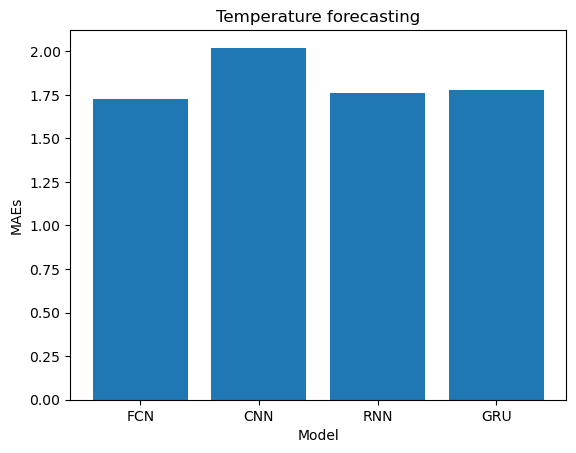

In [37]:
from torchmetrics.functional.regression import mean_absolute_error

models = [fcn_model, cnn_model, rnn_model, gru_model]
labels = ["FCN", "CNN", "RNN", "GRU"]
maes = []
for m in models:
    maes.append(mean_absolute_error(m(ds_test.tensors[0]).detach(), ds_test.tensors[1]).item())

plt.bar(labels, maes)
 
plt.xlabel("Model")
plt.ylabel("MAEs")
plt.title("Temperature forecasting")
plt.show()

## Multivariate Time Series Forecasting

Multivariate time series forecasting involves using multiple related features to predict future values of a target variable over time. Unlike univariate time series forecasting, which relies solely on historical values of a single column for predictions, multivariate forecasting considers information from multiple columns.

The objective of multivariate forecasting is to enhance prediction accuracy by capturing the intricate relationships and dependencies among these columns.

### Preparing the Data

In our example, we have a time series with the following 14 variables:

In [38]:
df.columns, len(df.columns)

(Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
        'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
        'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
        'wd (deg)'],
       dtype='object'),
 14)

To begin, we resample the data every six hours, incorporating the four columns as features. Any missing values will be replaced with values from the previous readings.

In [39]:
df_hourly = df[['T (degC)', 'Tdew (degC)', 'VPact (mbar)', 'H2OC (mmol/mol)']].resample('6h').fillna("bfill")
df_hourly.head()

,T (degC),Tdew (degC),VPact (mbar),H2OC (mmol/mol)
Date Time,,,,
2009-01-01 00:00:00,-8.02,-8.90,3.11,3.12
2009-01-01 06:00:00,-9.67,-10.62,2.71,2.72
2009-01-01 12:00:00,-6.87,-8.28,3.27,3.26
2009-01-01 18:00:00,-5.25,-6.75,3.68,3.68
2009-01-02 00:00:00,-4.54,-5.46,4.06,4.06


Next, we will use the function `timeseries_dataset_from_array` to create a time series dataset in a similar manner as before, but this time each sequence contains values with multiple features. To illustrate this, let's consider a scenario with 10 examples, each containing 3 features, where the third feature represents the target variable we are trying to predict the future values of. We will use a sequence length of 4, with the fifth value of the third feature being the future target to be predicted.

In [40]:
inputs = torch.arange(30).reshape(10,3)
targets = inputs[4:, 2]
inputs, targets

(tensor([[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8],
         [ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17],
         [18, 19, 20],
         [21, 22, 23],
         [24, 25, 26],
         [27, 28, 29]]),
 tensor([14, 17, 20, 23, 26, 29]))

Calling `timeseries_dataset_from_array` on this data results in the following dataset:

In [41]:
X, y = timeseries_dataset_from_array(sequence, targets, 4)
X, y

(tensor([[0, 1, 2, 3],
         [1, 2, 3, 4],
         [2, 3, 4, 5],
         [3, 4, 5, 6],
         [4, 5, 6, 7],
         [5, 6, 7, 8]]),
 tensor([14, 17, 20, 23, 26, 29]))

In [42]:
X.shape, y.shape

(torch.Size([6, 4]), torch.Size([6]))

Now that we understand how this process works, let's generate three sets of multivariate time series data: training, validation, and testing, without shuffling. We will use a sequence length of 20, representing one item every six hours for a total of 5 days. The targets correspond to the temperatures after these five days. Below is the code implementing this process:

In [43]:
from torch.utils.data import TensorDataset, DataLoader

inputs = torch.from_numpy(df_hourly.values).float()
targets = inputs[:, 0].float().unsqueeze(dim=1)

num_train_samples = int(0.5 * len(inputs))
num_val_samples = int(0.25 * len(inputs))
num_test_samples = len(inputs) - num_train_samples - num_val_samples

sequence_length = 20

ds_train = TensorDataset(*timeseries_dataset_from_array(
    inputs[:-sequence_length],
    targets[sequence_length:],
    sequence_length,
    start_index=0,
    end_index=num_train_samples))

ds_val = TensorDataset(*timeseries_dataset_from_array(
    inputs[:-sequence_length],
    targets[sequence_length:],
    sequence_length,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples))

ds_test = TensorDataset(*timeseries_dataset_from_array(
    inputs[:-sequence_length],
    targets[sequence_length:],
    sequence_length,
    start_index=num_train_samples + num_val_samples))

len(ds_train), len(ds_val), len(ds_test)

(5844, 2922, 2883)

And here are the corresponding data loaders

In [44]:
dl_train = DataLoader(ds_train, batch_size=16, num_workers=4, shuffle=False, 
                      persistent_workers=True, drop_last=True, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size=16, num_workers=4, shuffle=False,
                    persistent_workers=True, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=16, num_workers=4, shuffle=False,
                     persistent_workers=True, pin_memory=True)

To ensure everything is correct, let's display the shape of the first batch's input and output:

In [45]:
for samples, targets in dl_train:
    print("  Inputs:", samples.shape)
    print(" Targets:", targets.shape)
    break

  Inputs: torch.Size([16, 20, 4])
 Targets: torch.Size([16, 1])


The number 4 here represents the number of features.

### Building and Training Models

We are now ready to build and train multivariate forecasting models. First, we will construct, train, and evaluate a simple fully-connected model:

In [46]:
class MultiTempFCNForecaster(BaseForecaster):
    def __init__(self, lr=0.001):
        super().__init__(lr)
        self.lr = lr
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(80, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.fc(x)
        
multi_fcn_model = MultiTempFCNForecaster()
summary(multi_fcn_model)

Layer (type:depth-idx)                   Param #
MultiTempFCNForecaster                   --
├─MeanAbsoluteError: 1-1                 --
├─MeanAbsoluteError: 1-2                 --
├─MeanAbsoluteError: 1-3                 --
├─Sequential: 1-4                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       5,184
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       65
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0

Let's train this model.

In [47]:
logger = CSVLogger("logs", name="mv_ts_fcn")

trainer = L.Trainer(max_epochs=20, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1, 
        dirpath='checkpoints/', filename='mv_ts_fcn-{epoch:02d}-{val_loss:.2f}', 
    ),
    EarlyStopping(monitor='val_loss', patience=3, mode='min')
], logger=logger)
trainer.fit(multi_fcn_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory checkpoints/ exists and is not empty.

  | Name      | Type              | Params
------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0     
1 | val_mae   | MeanAbsoluteError | 0     
2 | test_mae  | MeanAbsoluteError | 0     
3 | fc        | Sequential        | 5.2 K 
------------------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


Sanity Checking: |                                          | 0/? [00:00<?, ?it/s]

Training: |                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Let's evaluate this model on the testing dataset.

In [48]:
trainer.test(ckpt_path='best', dataloaders=dl_test)

Restoring states from the checkpoint path at checkpoints/mv_ts_fcn-epoch=04-val_loss=10.29.ckpt
Loaded model weights from the checkpoint at checkpoints/mv_ts_fcn-epoch=04-val_loss=10.29.ckpt


Testing: |                                                  | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    11.593502044677734     │
│         test_mae          │     2.634284257888794     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 11.593502044677734, 'test_mae': 2.634284257888794}]

Let's plot the predicted temperatures alongside the actual ones.

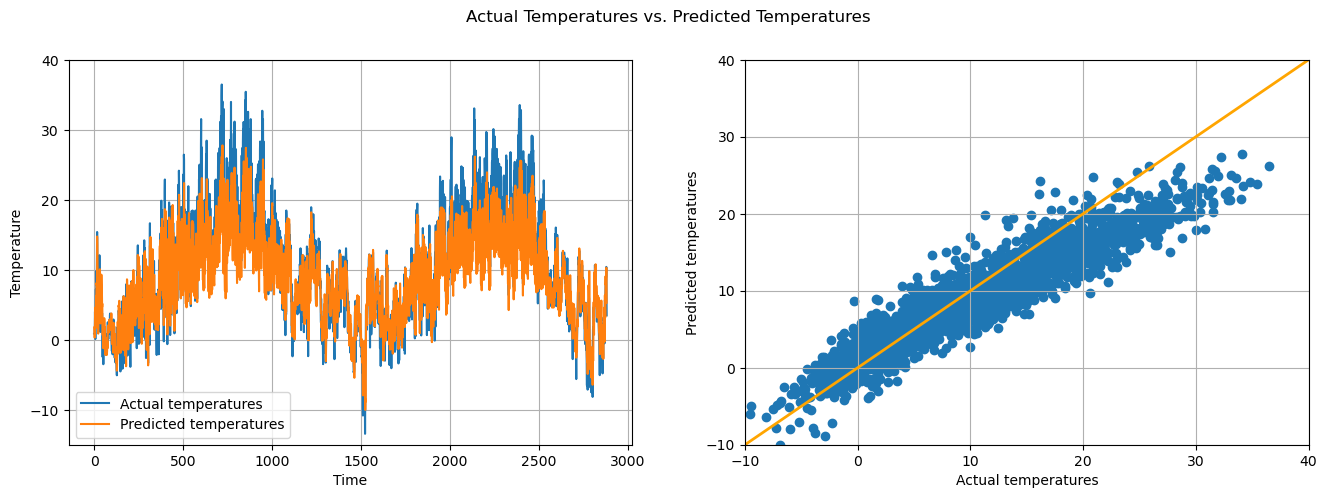

In [49]:
plot_actual_vs_predicted(multi_fcn_model, ds_test)

This is not good. 

Let's try a 1D convolutional model using the `Conv1D` and `MaxPooling1D` layers.

In [50]:
class MultiTempCNNForecaster(BaseForecaster):
    def __init__(self, lr=0.001):
        super().__init__(lr)
        
        self.cnn = nn.Sequential(
            nn.Conv1d(20, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.cnn(x)

multi_cnn_model = MultiTempCNNForecaster()
summary(multi_cnn_model)

Layer (type:depth-idx)                   Param #
MultiTempCNNForecaster                   --
├─MeanAbsoluteError: 1-1                 --
├─MeanAbsoluteError: 1-2                 --
├─MeanAbsoluteError: 1-3                 --
├─Sequential: 1-4                        --
│    └─Conv1d: 2-1                       976
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
│    └─Flatten: 2-4                      --
│    └─Linear: 2-5                       17
Total params: 993
Trainable params: 993
Non-trainable params: 0

Let's train this model.

In [51]:
logger = CSVLogger("logs", name="mv_ts_cnn")

trainer = L.Trainer(max_epochs=20, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1, 
        dirpath='checkpoints/', filename='mv_ts_cnn-{epoch:02d}-{val_loss:.2f}', 
    ),
    EarlyStopping(monitor='val_loss', patience=3, mode='min')
], logger=logger)
trainer.fit(multi_cnn_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory checkpoints/ exists and is not empty.

  | Name      | Type              | Params
------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0     
1 | val_mae   | MeanAbsoluteError | 0     
2 | test_mae  | MeanAbsoluteError | 0     
3 | cnn       | Sequential        | 993   
------------------------------------------------
993       Trainable params
0         Non-trainable params
993       Total params
0.004     Total estimated model params size (MB)


Sanity Checking: |                                          | 0/? [00:00<?, ?it/s]

Training: |                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Let's evaluate this model on the testing dataset.

In [52]:
trainer.test(ckpt_path='best', dataloaders=dl_test)

Restoring states from the checkpoint path at checkpoints/mv_ts_cnn-epoch=03-val_loss=19.94.ckpt
Loaded model weights from the checkpoint at checkpoints/mv_ts_cnn-epoch=03-val_loss=19.94.ckpt


Testing: |                                                  | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    20.294206619262695     │
│         test_mae          │    3.5105996131896973     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 20.294206619262695, 'test_mae': 3.5105996131896973}]

Let's plot the predicted temperatures alongside the actual ones.

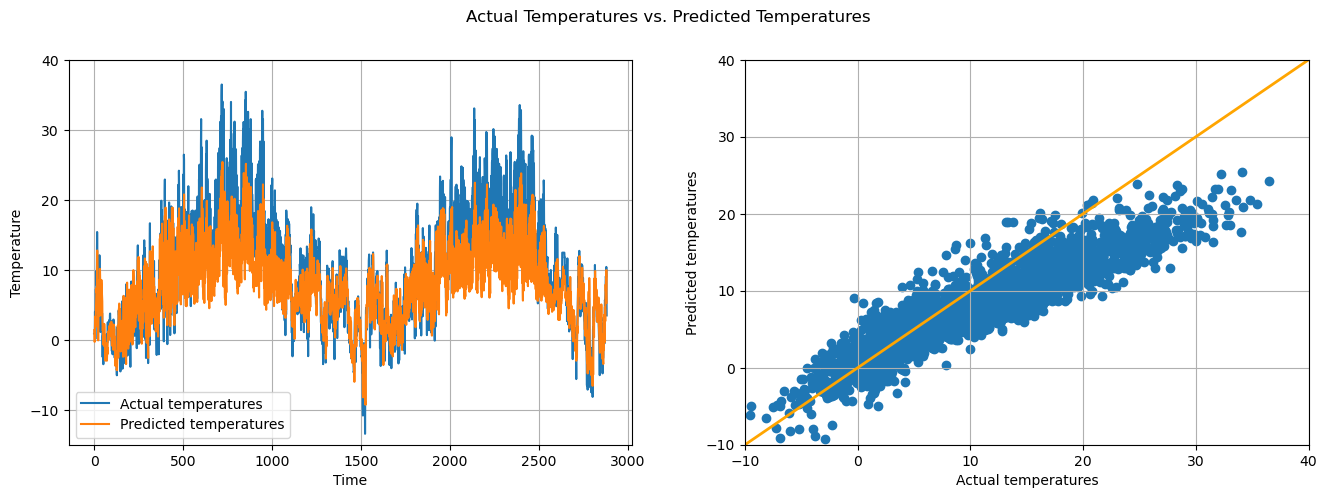

In [53]:
plot_actual_vs_predicted(multi_cnn_model, ds_test)

Finally, we try an RNN model with an LSTM (Long Short Term Memory) layer. Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture designed to address the vanishing gradient problem and capture long-term dependencies in sequential data. It is particularly effective for tasks involving time series data, natural language processing, speech recognition, and more.

In [54]:
class MultiTempLSTMForecaster(BaseForecaster):
    def __init__(self, lr=0.001):
        super().__init__(lr)

        self.lstm = nn.LSTM(input_size=4, hidden_size=24, batch_first=True)
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(480, 1)
        )

    def forward(self, x):
        o, _ = self.lstm(x)
        # o, _ = self.lstm2(o)
        return self.out(o)

multi_lstm_model = MultiTempLSTMForecaster()
summary(multi_lstm_model)


Layer (type:depth-idx)                   Param #
MultiTempLSTMForecaster                  --
├─MeanAbsoluteError: 1-1                 --
├─MeanAbsoluteError: 1-2                 --
├─MeanAbsoluteError: 1-3                 --
├─LSTM: 1-4                              2,880
├─Sequential: 1-5                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       481
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0

Let's train this model.

In [55]:
logger = CSVLogger("logs", name="mv_ts_lstm")

trainer = L.Trainer(max_epochs=20, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1, 
        dirpath='checkpoints/', filename='mv_ts_lstm-{epoch:02d}-{val_loss:.2f}', 
    ),
    EarlyStopping(monitor='val_loss', patience=3, mode='min')
], logger=logger)
trainer.fit(multi_lstm_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory checkpoints/ exists and is not empty.

  | Name      | Type              | Params
------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0     
1 | val_mae   | MeanAbsoluteError | 0     
2 | test_mae  | MeanAbsoluteError | 0     
3 | lstm      | LSTM              | 2.9 K 
4 | out       | Sequential        | 481   
------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.013     Total estimated model params size (MB)


Sanity Checking: |                                          | 0/? [00:00<?, ?it/s]

Training: |                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Let's evaluate this model on the testing dataset.

In [56]:
trainer.test(ckpt_path='best', dataloaders=dl_test)

Restoring states from the checkpoint path at checkpoints/mv_ts_lstm-epoch=04-val_loss=14.06.ckpt
Loaded model weights from the checkpoint at checkpoints/mv_ts_lstm-epoch=04-val_loss=14.06.ckpt


Testing: |                                                  | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    15.464418411254883     │
│         test_mae          │    3.0400123596191406     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 15.464418411254883, 'test_mae': 3.0400123596191406}]

Let's plot the predicted temperatures alongside the actual ones.

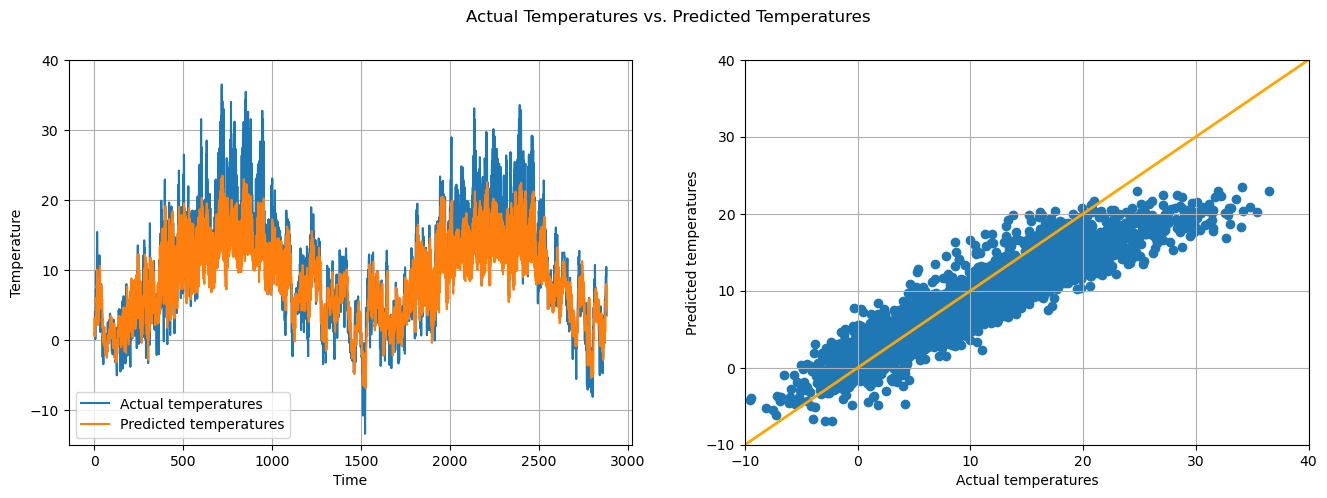

In [57]:
plot_actual_vs_predicted(multi_lstm_model, ds_test)

I will leave it as an exercise for you to compare the results of these three models.